# Bank Marketing — Full EDA + Modeling + SHAP

A complete, self-contained notebook for the UCI Bank Marketing dataset. Sections: imports, data loading, EDA, profiling (ydata/pandas-profiling), feature engineering, preprocessing pipeline, model comparison (LR, RF, LGB/XGB if available), SHAP explainability, and model export.

Run cells sequentially. Adjust `PROJECT_ROOT` if automatic detection doesn't work.

In [3]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

print('Imports OK')

Imports OK


In [4]:
## Project root detection

try:
    PROJECT_ROOT = Path().resolve()
    if PROJECT_ROOT.name.lower() in ('notebooks','notebook'):
        PROJECT_ROOT = PROJECT_ROOT.parent
except Exception:
    PROJECT_ROOT = None

if PROJECT_ROOT is None or not PROJECT_ROOT.exists():
    PROJECT_ROOT = Path('/mnt/data')  # fallback for notebook environment

DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'figures'
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_RAW:', DATA_RAW)
print('REPORTS_DIR:', REPORTS_DIR)


PROJECT_ROOT: D:\development\ML Dev projects\Bank-Marketing-ML-Dev
DATA_RAW: D:\development\ML Dev projects\Bank-Marketing-ML-Dev\data\raw
REPORTS_DIR: D:\development\ML Dev projects\Bank-Marketing-ML-Dev\reports\figures


In [5]:
## Load the dataset

csv_path = DATA_RAW / 'bank-full.csv'
if not csv_path.exists():
    for alt in ['bank.csv','bank_marketing.csv','bank-full.csv']:
        p = DATA_RAW / alt
        if p.exists():
            csv_path = p
            break

if not csv_path.exists():
    raise FileNotFoundError(f'Data file not found in {DATA_RAW}. Please place bank-full.csv there.')

print('Reading:', csv_path)
data = pd.read_csv(csv_path, sep=';', quotechar='"')
print('Shape:', data.shape)
display(data.head())
data.info()


Reading: D:\development\ML Dev projects\Bank-Marketing-ML-Dev\data\raw\bank-full.csv
Shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [6]:
## Column typing (categorical / numerical / binary)
from pandas.api.types import is_numeric_dtype, is_object_dtype, is_categorical_dtype

cat_threshold = 10
categorical_cols = []
numerical_cols = []
binary_cols = []

for col in data.columns:
    unique_vals = data[col].nunique()
    if unique_vals == 2:
        binary_cols.append(col)
        continue
    if is_object_dtype(data[col]) or is_categorical_dtype(data[col]) or unique_vals < cat_threshold:
        categorical_cols.append(col)
        continue
    if is_numeric_dtype(data[col]):
        numerical_cols.append(col)

print('Categorical:', categorical_cols)
print('Numerical:', numerical_cols)
print('Binary   :', binary_cols)


Categorical: ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
Numerical: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Binary   : ['default', 'housing', 'loan', 'y']


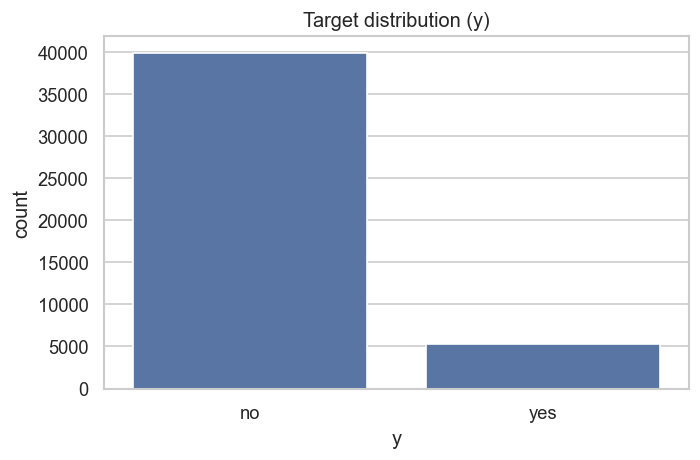

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64


In [7]:
## Target distribution
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='y')
plt.title('Target distribution (y)')
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'target_distribution.png')
plt.show()
print(data['y'].value_counts(normalize=True))


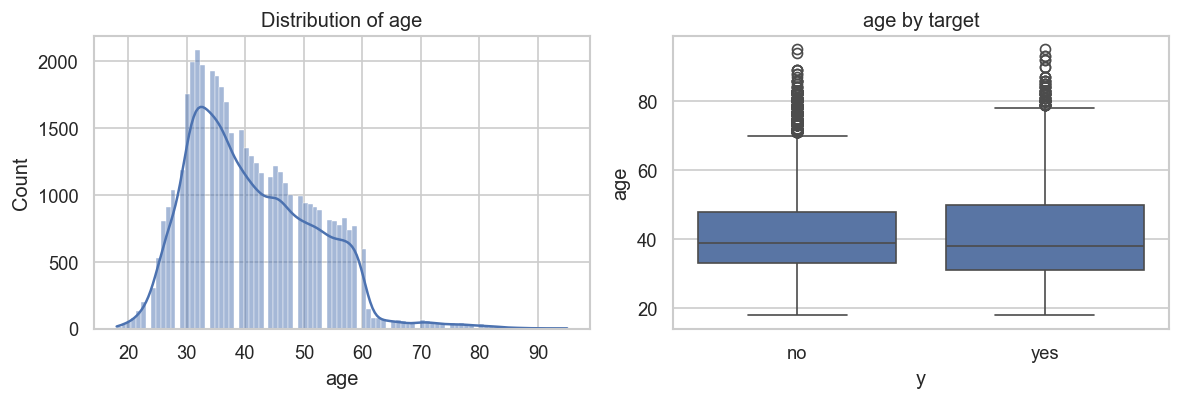

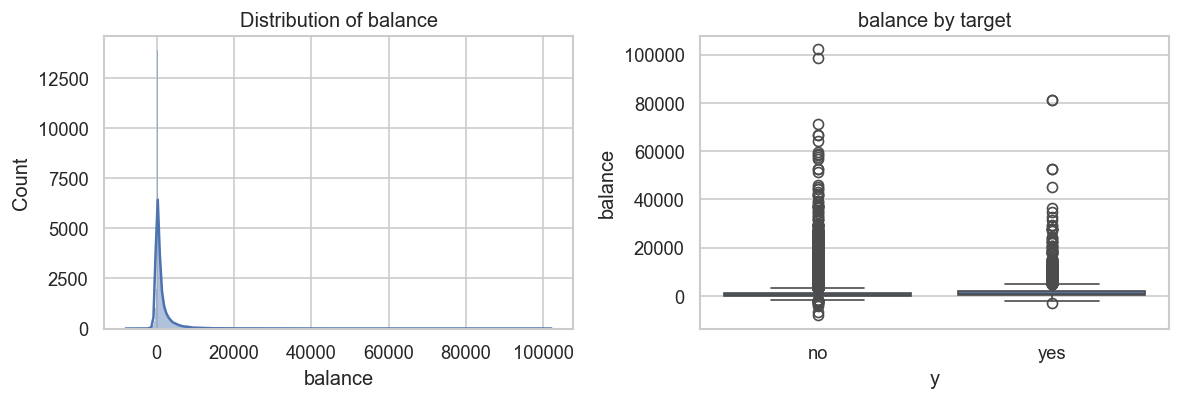

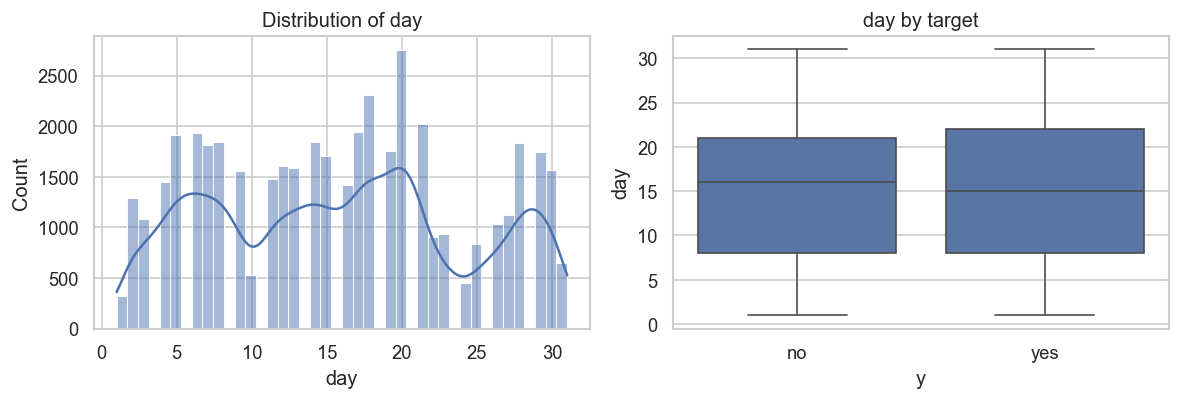

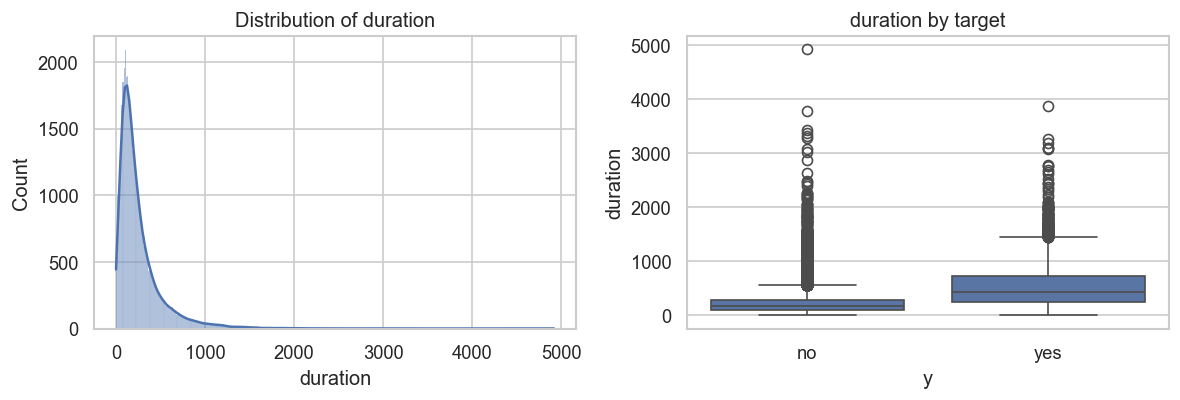

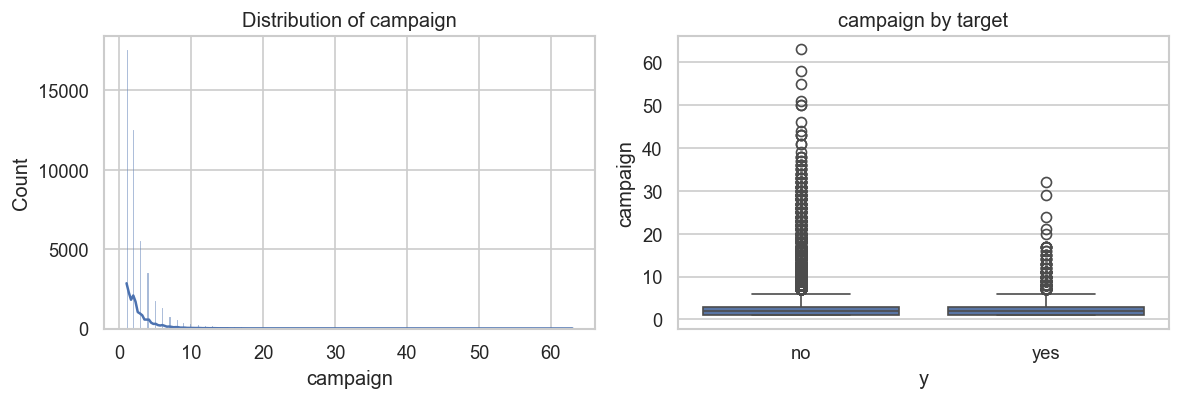

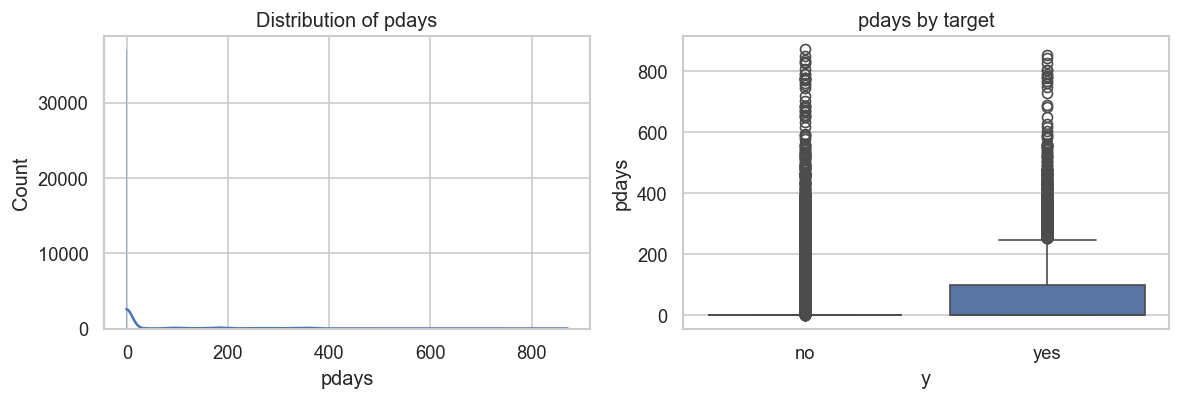

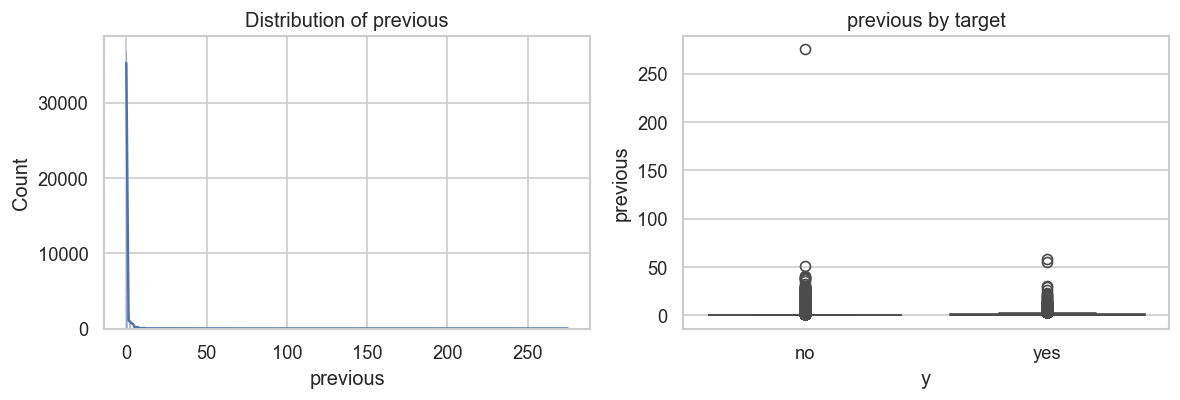

In [8]:
## Numerical exploration (hist + boxplot)
for col in numerical_cols:
    fig, axes = plt.subplots(1,2,figsize=(10,3.5))
    sns.histplot(data=data, x=col, kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {col}')
    sns.boxplot(data=data, x='y', y=col, ax=axes[1])
    axes[1].set_title(f'{col} by target')
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / f'num_{col}.png')
    plt.show()


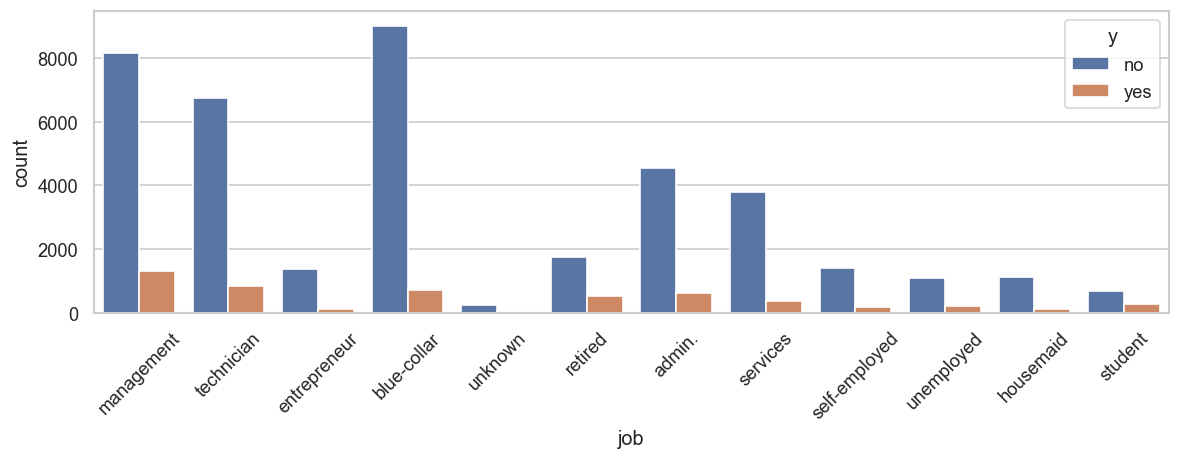

Conversion rate by job:


job
student          0.286780
retired          0.227915
unemployed       0.155027
management       0.137556
admin.           0.122027
self-employed    0.118429
unknown          0.118056
technician       0.110570
services         0.088830
housemaid        0.087903
entrepreneur     0.082717
blue-collar      0.072750
Name: y, dtype: float64

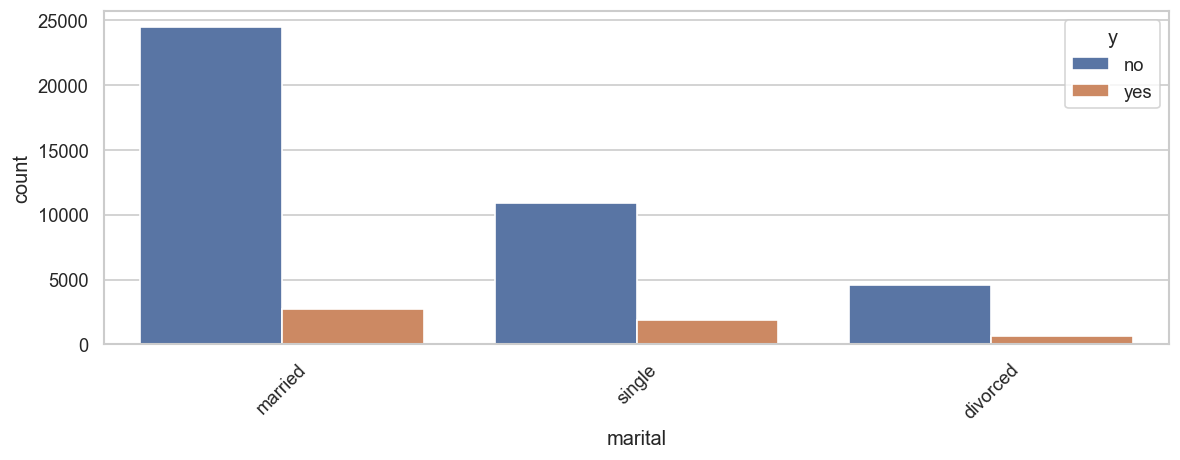

Conversion rate by marital:


marital
single      0.149492
divorced    0.119455
married     0.101235
Name: y, dtype: float64

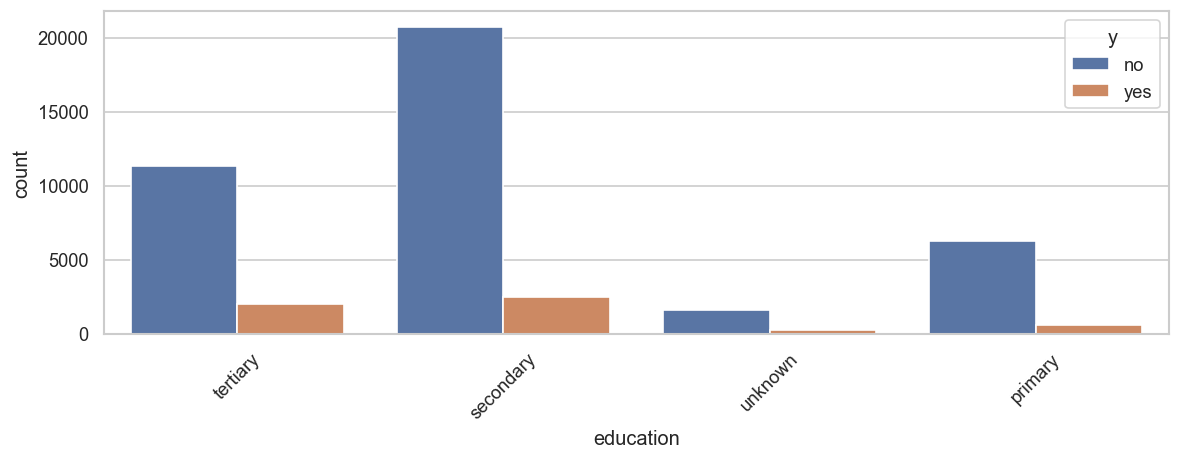

Conversion rate by education:


education
tertiary     0.150064
unknown      0.135703
secondary    0.105594
primary      0.086265
Name: y, dtype: float64

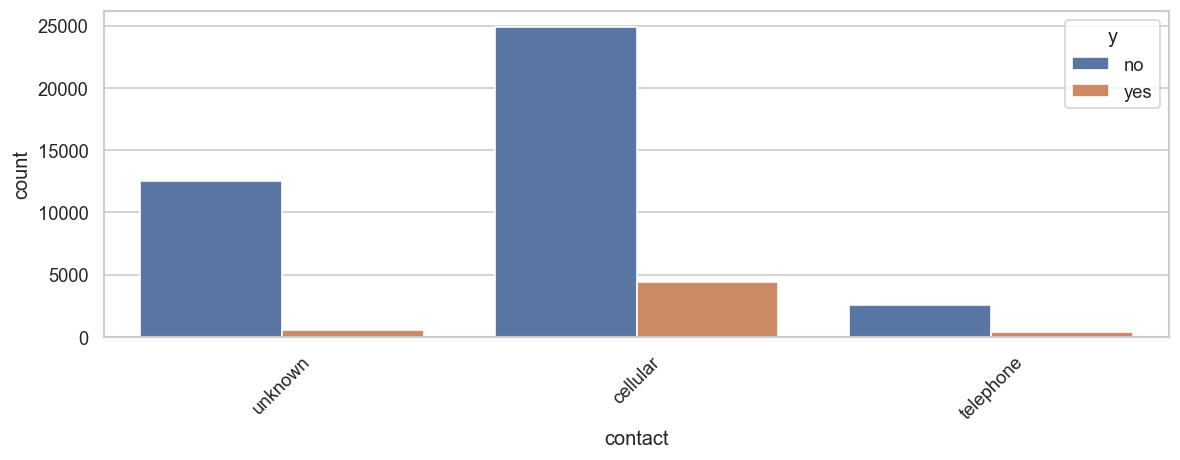

Conversion rate by contact:


contact
cellular     0.149189
telephone    0.134205
unknown      0.040707
Name: y, dtype: float64

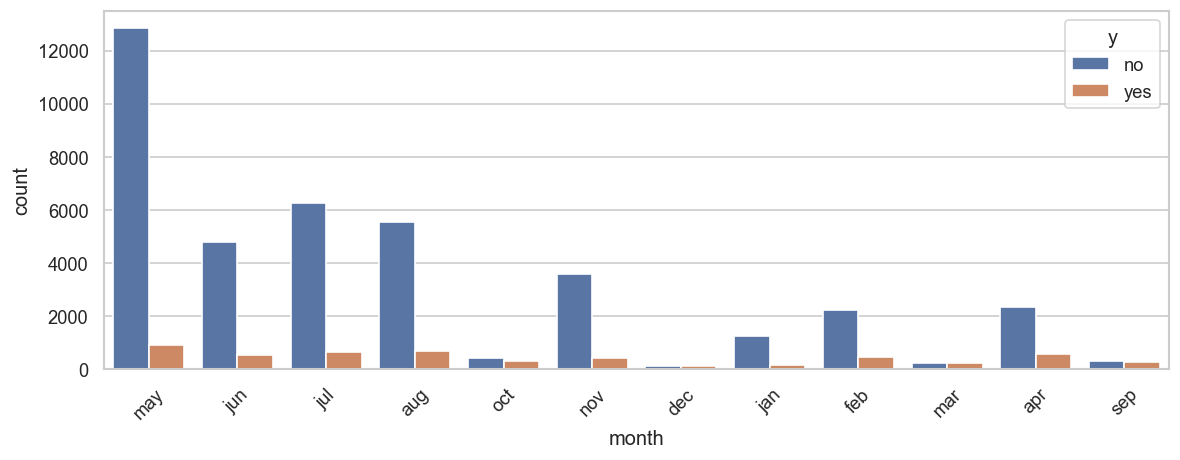

Conversion rate by month:


month
mar    0.519916
dec    0.467290
sep    0.464594
oct    0.437669
apr    0.196794
feb    0.166478
aug    0.110133
jun    0.102228
nov    0.101511
jan    0.101212
jul    0.090935
may    0.067195
Name: y, dtype: float64

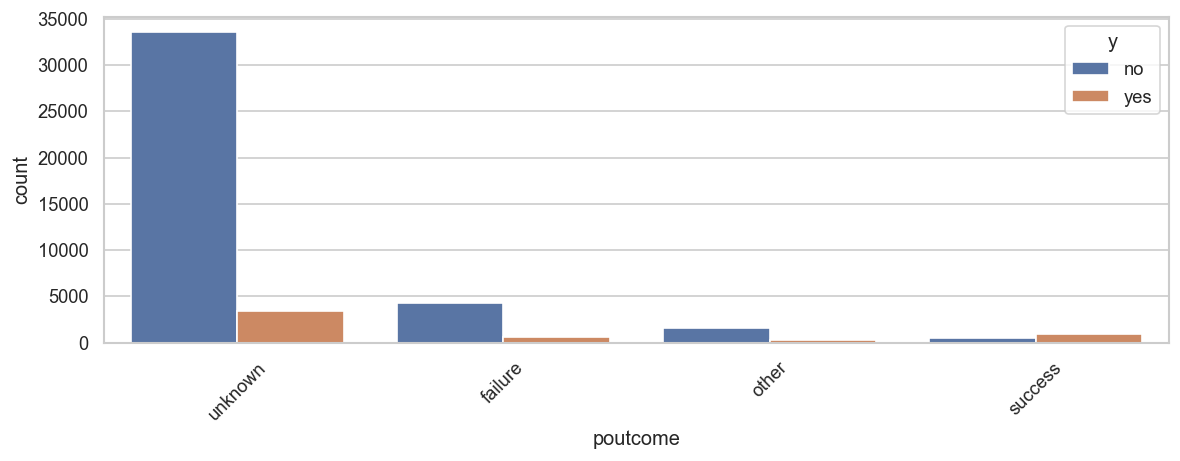

Conversion rate by poutcome:


poutcome
success    0.647253
other      0.166848
failure    0.126097
unknown    0.091615
Name: y, dtype: float64

In [9]:
## Categorical exploration (countplots + conversion rates)
for col in categorical_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(data=data, x=col, hue='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / f'cat_{col}_counts.png')
    plt.show()
    conv = data.groupby(col)['y'].apply(lambda x: (x=='yes').mean()).sort_values(ascending=False)
    print(f'Conversion rate by {col}:')
    display(conv)


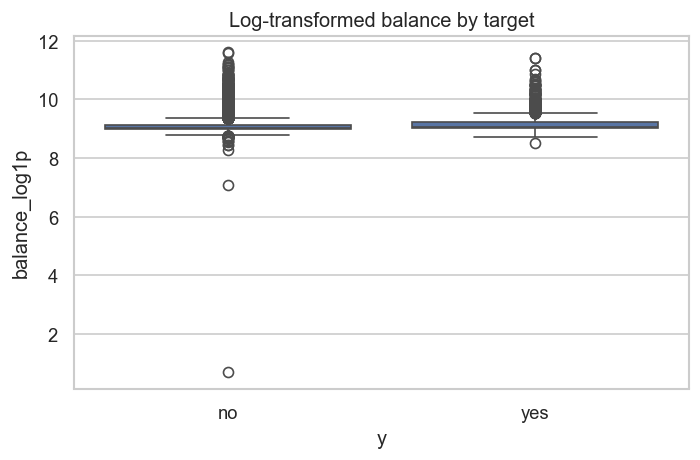

In [10]:
## Feature engineering suggestions + create features for EDA
edata = data.copy()
if 'pdays' in edata.columns:
    edata['pdays_not_contacted'] = (edata['pdays'] == 999).astype(int)
edata['balance_log1p'] = np.log1p(edata['balance'] - edata['balance'].min() + 1)

edata['campaign_bucket'] = pd.cut(edata['campaign'], bins=[-1,0,1,2,4,10,100], labels=['0','1','2','3-4','5-10','10+'])

plt.figure(figsize=(6,4))
sns.boxplot(data=edata, x='y', y='balance_log1p')
plt.title('Log-transformed balance by target')
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'balance_log1p_by_y.png')
plt.show()


In [11]:
## Profiling (ydata & pandas-profiling)
output_profile_dir = REPORTS_DIR.parent / 'profiling'
output_profile_dir.mkdir(parents=True, exist_ok=True)

try:
    from ydata_profiling import ProfileReport
    profile = ProfileReport(data, title='Bank Marketing - YData Profiling', explorative=True)
    profile.to_file(output_profile_dir / 'bank_ydata_profile.html')
    print('Saved ydata profiling report')
except Exception as e:
    print('ydata_profiling error:', e)

try:
    from pandas_profiling import ProfileReport as PandasProfile
    p_old = PandasProfile(data, title='Bank Marketing - Pandas Profiling')
    p_old.to_file(output_profile_dir / 'bank_pandas_profile.html')
    print('Saved pandas-profiling report')
except Exception as e:
    print('pandas_profiling error:', e)


ydata_profiling error: No module named 'ydata_profiling'
pandas_profiling error: No module named 'pandas_profiling'


In [12]:
## Prepare modeling dataset (drop duration for production)
from sklearn.model_selection import train_test_split

model_df = data.copy()
model_df['y_bin'] = model_df['y'].map({'no':0,'yes':1})
features = [c for c in model_df.columns if c not in ['y','y_bin','duration']]
cat_cols = [c for c in features if model_df[c].dtype=='object']
num_cols = [c for c in features if np.issubdtype(model_df[c].dtype, np.number)]

X = model_df[features]
y = model_df['y_bin']

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Numeric cols:', num_cols)
print('Categorical cols:', cat_cols)


Train shape: (36168, 15) Test shape: (9043, 15)
Numeric cols: ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
Categorical cols: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [14]:
## Preprocessing and models
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
import joblib

numeric_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer([('num', numeric_pipeline, num_cols), ('cat', cat_pipeline, cat_cols)], remainder='drop')

models = {
    'logistic': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'rf': RandomForestClassifier(n_jobs=-1, class_weight='balanced')
}

# add lgb/xgb if available
try:
    import lightgbm as lgb
    models['lgb'] = lgb.LGBMClassifier(n_jobs=-1)
except Exception:
    print('LightGBM not available')
try:
    import xgboost as xgb
    models['xgb'] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
except Exception:
    print('XGBoost not available')

results = {}
model_path = PROJECT_ROOT / 'models'
model_path.mkdir(exist_ok=True, parents=True)

for name, estimator in models.items():
    print('\nTraining pipeline for:', name)
    pipe = Pipeline([('preproc', preprocessor), ('clf', estimator)])
    pipe.fit(X_train, y_train)

    if hasattr(pipe, 'predict_proba'):
        y_prob = pipe.predict_proba(X_test)[:,1]
    else:
        y_prob = pipe.named_steps['clf'].predict_proba(preprocessor.transform(X_test))[:,1]
    y_pred = (y_prob > 0.5).astype(int)

    print('Model:', name)
    print(classification_report(y_test, y_pred))
    print('ROC AUC:', roc_auc_score(y_test, y_prob))
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    print('PR AUC:', pr_auc)

    joblib.dump(pipe, model_path / f'{name}_pipeline.joblib')
    print('Saved pipeline to', model_path / f'{name}_pipeline.joblib')
    results[name] = {'roc_auc': roc_auc_score(y_test, y_prob), 'pr_auc': pr_auc}

print('\nModel comparison results:')
print(results)


LightGBM not available
XGBoost not available

Training pipeline for: logistic
Model: logistic
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      7985
           1       0.27      0.62      0.37      1058

    accuracy                           0.75      9043
   macro avg       0.60      0.70      0.61      9043
weighted avg       0.86      0.75      0.79      9043

ROC AUC: 0.7722383533397332
PR AUC: 0.40865301877676813
Saved pipeline to D:\development\ML Dev projects\Bank-Marketing-ML-Dev\models\logistic_pipeline.joblib

Training pipeline for: rf
Model: rf
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7985
           1       0.66      0.22      0.33      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.60      0.63      9043
weighted avg       0.88      0.90      0.87      9043

ROC AUC: 0.7898298795117973
PR AUC: 0.430868663160323
Sa

In [15]:
## GridSearch example (RF)
from sklearn.model_selection import GridSearchCV
param_grid = {'clf__n_estimators':[100,300],'clf__max_depth':[None,6,12]}
rf_pipe = Pipeline([('preproc', preprocessor), ('clf', RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42))])
grid = GridSearchCV(rf_pipe, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)
print('Best CV score:', grid.best_score_)
joblib.dump(grid.best_estimator_, model_path / 'rf_grid_best.joblib')
print('Saved best RF grid model')


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__max_depth': 12, 'clf__n_estimators': 100}
Best CV score: 0.7824657627544354
Saved best RF grid model


In [ ]:
## SHAP explainability (for tree-based models)
try:
    import shap
    # pick a tree model if present
    tree_name = None
    for k in ['rf','lgb','xgb']:
        if k in results or (PROJECT_ROOT / 'models' / f'{k}_pipeline.joblib').exists():
            tree_name = k
            break
    if tree_name is None:
        print('No tree model detected (rf/lgb/xgb). Skipping SHAP.')
    else:
        print('Using model:', tree_name)
        pipe = joblib.load(model_path / f'{tree_name}_pipeline.joblib')
        # get preprocessed feature matrix for X_test
        X_test_prep = pipe.named_steps['preproc'].transform(X_test)
        # shap explain on the underlying model
        explainer = shap.Explainer(pipe.named_steps['clf'])
        shap_values = explainer(X_test_prep)
        shap.plots.beeswarm(shap_values, max_display=20)
except Exception as e:
    print('SHAP error or not installed:', e)


Using model: rf


In [ ]:
## Save small summaries and README
# missing summary
missing_df = data.isnull().sum().rename('missing_count').to_frame()
missing_df['missing_pct'] = missing_df['missing_count'] / len(data)
missing_df.to_csv(output_profile_dir / 'missing_summary.csv')

col_summary = pd.DataFrame({'dtype': data.dtypes.astype(str), 'nunique': data.nunique()})
col_summary.to_csv(output_profile_dir / 'columns_summary.csv')

# correlation with target
if 'y' in data.columns:
    numeric_for_corr = data.select_dtypes(include=[np.number]).copy()
    numeric_for_corr['y_num'] = data['y'].map({'no':0,'yes':1})
    numeric_for_corr.corr()['y_num'].sort_values(ascending=False).to_csv(output_profile_dir / 'corr_with_target.csv')

# README
readme = model_path / 'README.md'
readme.write_text('# Trained models\n\nPipelines saved: logistic_pipeline.joblib, rf_pipeline.joblib, lgb_pipeline.joblib (if present)\n')
print('Wrote README at', readme)
